# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.options.display.max_colwidth = 1000
pd.option_context('display.float_format', '{:0.20f}'.format)
pd.options.display.float_format = "{:.2f}".format
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)


from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,nan
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.00
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,nan
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.00
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,nan


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# A.DATA PROCESSING

### 1. portfolio dataframe

In [5]:
#Checking for duplicates
portfolio.duplicated(subset=["difficulty","duration","id","offer_type","reward"]).sum()

0

Portfolio dataframe does not have any duplicate rows. From this check we excluded column:channels 
because this column is a list and creates problems in the particular function. This problem is better addressed [here](https://stackoverflow.com/questions/13675296/how-to-overcome-typeerror-unhashable-type-list).
Therefore, having no duplicates for a subset of columns, that means that portoflio dataframe has no duplicates

In [6]:
#Checking for null values
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


We do not have any null values for any column in portfolio dataframe. 

In order to have a better contol of the portfolio dataframe we apply the below changes:

1) we will tranform the values of the column channels to the corresponding dummy variables: web, email, mobile, social

2) we will rename column:id into offer_id, so as they are distinguishable from other columns named after id, in other dataframes, in case of merging

3) we will rename column:difficult into required_spending, so as its name to be more obvious about the info of its values

4) we will rename column:duration into duration_days, so the time unit is obvious


In [7]:
#We create dummys variabels out of values of column channels and drop it 
portfolio=pd.merge(portfolio.drop(["channels"],axis=1), 
                portfolio["channels"].str.join(sep=",").str.get_dummies(sep=","), 
                left_index=True, right_index=True)
#We change the name of column: id into offer_id and of column:difficulty into required_spending
portfolio=portfolio.rename(columns = {"id":"offer_id","difficulty":"required_spending","duration":"duration_days"})

portfolio

,required_spending,duration_days,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


### 2. profile dataframe

In [8]:
profile.head(20)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,nan
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.00
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,nan
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.00
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,nan
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.00
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,nan
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,nan
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.00
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,nan


In [9]:
#Checking for duplicates
profile.duplicated().sum()

0

Dataframe profile does not seem to have any duplicates. But it seems that when age 

In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


From the above it seems incοme and gender having missing values for the same entries.

Let's check the unique values of each column

In [11]:
print("Unique value for age:",profile.age.nunique(),"\n",
      "Unique value for became_member_on:",profile.became_member_on.nunique(),"\n",
      "Unique value for gender:",profile.gender.nunique(),"\n",
      "Unique value for id:",profile.id.nunique(),"\n",
      "Unique value for income:",profile.income.nunique())

Unique value for age: 85 
 Unique value for became_member_on: 1716 
 Unique value for gender: 3 
 Unique value for id: 17000 
 Unique value for income: 91


In [12]:
#Encode missing values for gender
profile.loc[(profile.gender.isnull()) , 'Gender_null'] = 'null'
profile.loc[(profile.gender.notna()) , 'Gender_null'] = 'not_null'
#Encode missing values for income
profile.loc[(profile.income.isnull()) , 'income_null'] = 'null'
profile.loc[(profile.income.notna()) , 'income_null'] = 'not_null'

#Have a cross table to check if these missing values are identical
pd.crosstab(profile.Gender_null, profile.income_null)

income_null,not_null,null
Gender_null,,
not_null,14825,0
null,0,2175


So we that our initial thought is true. 

Something else that needs to be checked is the age column. The reason is that by observing the first 20 rows of the table we see that a value 118 repeats multiple times. And because this is not an expected value for age, this might be a encoded missing value.

In [13]:
#Encode missing values for gender
profile.loc[(profile.age==118) , 'age_118'] = '118'
profile.loc[(profile.age!=118) , 'age_118'] = 'not_118'

profile.groupby('age_118')['age'].count()


age_118
118         2175
not_118    14825
Name: age, dtype: int64

We have the same number of missing values for gender and income as the occurences of age=118 in the dataframe. We want to check if this happens for the same entries. If yes then we can be positive to consider them as missing values

In [14]:
pd.crosstab(profile.Gender_null, profile.age_118)


age_118,118,not_118
Gender_null,,
not_null,0,14825
null,2175,0


So yes! Age 118 happens for the same entries that columns gender and income has missing values. We consider values 118 for age as missing values and we encode them as missing values.

Furthermore, we rename column:id into customer_id, in order to the name of the column represent better the type of its information 


In [15]:
#drop check columns Gender_null, income_null & age_118
profile=profile.drop(["Gender_null", "income_null","age_118"], axis=1)

In [16]:
#Replace values 118 for column afe into missing values
profile.age.replace({118:np.nan}, inplace=True)

#Change name of column:id into customer_id
profile=profile.rename(columns = {"id":"customer_id"})
profile.head()

,age,became_member_on,gender,customer_id,income
0,nan,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,nan
1,55.00,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.00
2,nan,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,nan
3,75.00,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.00
4,nan,20170804,None,a03223e636434f42ac4c3df47e8bac43,nan


### 3. transcript dataframe

In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [19]:
print("Unique value for event:",transcript.event.nunique(),"\n",
      "Unique value for person:",transcript.person.nunique(),"\n",
      "Unique value for time:",transcript.time.nunique())

Unique value for event: 4 
 Unique value for person: 17000 
 Unique value for time: 120


It seems that this dataframe has no missing value. Also column: person, which represents the customer id, we have the same unique values as customer id had in dataframe profile.

From the description of the dataframe and a print of the first 5 rows we see that column value has combined information. Therefore, we will try to further investigate it

In [20]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

So column value has compact information about every stage of an offer. 

In [21]:
"""
column transcript.value takes 3 kind of values:
1) offer_id:id of the offer that was given to customer. 
2) offer_id:id of the offer that was given to customer, reward:reward that was finally given to customer
3) amount: the amount that was spend from customer

So column value includes information of when an offer was given, of the reward it was given to customer 
and the value of the transactions were happened. So we will create dataframe:value_df from values of column transcript.value.
value_df will have 3 columns:
offer_id: id of the offer that was given to customer
amount:   the amount that was spend from customer
reward:   reward that was finally given to customer
"""
value_df=pd.DataFrame(transcript['value'].apply(pd.Series))

value_df['offer id'].fillna(value_df['offer_id'], inplace = True)
value_df.drop(columns='offer_id', inplace = True)
value_df=value_df.rename(columns = {"offer id":"offer_id"})

value_df.tail(10)

,offer_id,amount,reward
306524,NaN,25.14,nan
306525,NaN,43.58,nan
306526,NaN,22.64,nan
306527,fafdcd668e3743c1bb461111dcafc2a4,nan,2.00
306528,NaN,2.20,nan
306529,NaN,1.59,nan
306530,NaN,9.53,nan
306531,NaN,3.61,nan
306532,NaN,3.53,nan
306533,NaN,4.05,nan


We merge with transact, so we have the information in the main dataframe and we transform the values of column time into days, creating the new variable time_days.

After that we drop the initial column time

In [22]:
transcript=pd.merge(transcript.drop(["value"],axis=1), value_df, left_index=True, right_index=True)
transcript['time_days']=transcript.time/24
transcript=transcript.drop(columns='time')
transcript.head()

,event,person,offer_id,amount,reward,time_days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,nan,nan,0.00
1,offer received,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,nan,0.00
2,offer received,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,nan,nan,0.00
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,nan,nan,0.00
4,offer received,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,nan,nan,0.00


Now it's a good time to explore the unique values of the infromation that was generated from the initial column:value

In [23]:
print("Unique value for offer_id:",transcript.offer_id.nunique(),"\n",
      "Unique value for amount:",transcript.amount.nunique(),"\n",
      "Unique value for reward:",transcript.reward.nunique())

Unique value for offer_id: 10 
 Unique value for amount: 5103 
 Unique value for reward: 4


For better understanding of transcript dataframe, we will explore the values of column:event

In [24]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [25]:
pd.crosstab(transcript.event, transcript.time_days)

time_days,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.0,7.25,7.5,7.75,8.0,8.25,8.5,8.75,9.0,9.25,9.5,9.75,10.0,10.25,10.5,10.75,11.0,11.25,11.5,11.75,12.0,12.25,12.5,12.75,13.0,13.25,13.5,13.75,14.0,14.25,14.5,14.75,15.0,15.25,15.5,15.75,16.0,16.25,16.5,16.75,17.0,17.25,17.5,17.75,18.0,18.25,18.5,18.75,19.0,19.25,19.5,19.75,20.0,20.25,20.5,20.75,21.0,21.25,21.5,21.75,22.0,22.25,22.5,22.75,23.0,23.25,23.5,23.75,24.0,24.25,24.5,24.75,25.0,25.25,25.5,25.75,26.0,26.25,26.5,26.75,27.0,27.25,27.5,27.75,28.0,28.25,28.5,28.75,29.0,29.25,29.5,29.75
event,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
offer completed,206,276,280,252,265,275,258,227,234,224,189,201,188,190,143,134,134,122,120,104,122,66,86,84,75,78,75,50,367,316,370,376,345,339,319,306,262,244,231,200,188,175,156,159,131,138,108,133,119,76,94,68,94,60,68,67,428,380,396,358,333,299,309,310,282,280,228,210,647,607,562,511,494,539,429,399,382,359,348,304,245,226,235,189,614,586,536,508,484,450,436,420,334,339,311,304,690,570,631,553,551,510,426,455,402,344,312,309,269,227,226,229,213,151,152,130,148,101,99,103
offer received,12650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12669,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12711,0,0,0,0,0,0,0,0,0,0,0,12778,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12704,0,0,0,0,0,0,0,0,0,0,0,12765,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
offer viewed,2072,1433,1085,884,734,593,474,367,316,280,209,201,161,137,134,117,88,101,92,76,74,53,52,50,47,49,39,25,2120,1543,1156,910,707,539,482,370,315,255,205,174,173,154,116,108,100,95,92,79,79,67,56,54,50,42,35,28,2103,1537,1131,868,692,592,482,391,283,266,228,190,2210,1578,1207,933,727,524,475,399,308,264,240,196,181,140,137,144,2153,1559,1220,867,680,558,451,387,327,269,250,217,2152,1557,1188,897,723,616,498,360,333,265,245,210,206,164,124,121,124,111,93,87,74,59,57,50
transaction,633,797,850,879,922,1028,1000,1056,1060,1015,1030,1085,1024,981,1046,984,1026,970,892,926,972,864,814,834,833,767,800,835,994,964,1133,1120,1160,1097,1199,1215,1267,1255,1229,1177,1204,1104,988,1071,1029,1061,1006,963,1001,867,923,912,887,838,865,843,1060,1100,1128,1196,1169,1241,1225,1308,1233,1296,1257,1268,1395,1398,1377,1464,1469,1528,1463,1427,1372,1394,1381,1359,1366,1264,1247,1153,1351,1369,1397,1408,1405,1457,1409,1385,1334,1335,1367,1371,1408,1357,1403,1487,1465,1459,1451,1491,1439,1352,1377,1342,1326,1208,1249,1261,1258,1089,1139,1043,1104,955,892,977


So we will create a new dataframe which will aggreagate all the information of dataframe transcript.
For this reason the aggregated dataframe will be combined with 

This dataframe will have the following columns:

1) customer_id: it will be the key for the customer id (as in dataframe profile)

2) offer_id: it will represent the offer which was given to client

3) offer_type: it is the category of the offer_id (the information derives from portfolio dataframe)

4) email: Binary column, it represents the channel of the offer can email or not (the information derives from portfolio dataframe)

5) mobile: Binary column, it represents the channel of the offer can mobile or not (the information derives from portfolio dataframe)

6) social: Binary column, it represents the channel of the offer can social or not (the information derives from portfolio dataframe)

7) web: Binary column, it represents the channel of the offer can social or not (the information derives from portfolio dataframe)

8) required_spending: It is the required amount that should be spent in order customer takes the offer (the information derives from portfolio dataframe)

9) duration_days: it is the time in days that the offer is active (the information derives from portfolio dataframe)

10) time_received: it will represent the time in days, since the start of the test, when customer receives offer

11) time_viewed: it will represent the time in days, since the start of the test, when customer first views the offer 

12) days_first_trans: it will represent the time in days when the customer will make their first transaction after having received the offer. THIS IS ESSENTIAL. THIS VARIABLE WILL HAVE INFORMATION FOR TRANSACTION TIME INDEPENDENTLY IF CUSTOMER HAVE SEEN THE OFFER

13) time_completed: it will represent the time in days, since the start of the test, when the offer is completed

14) reward_amount: it the worth of the amount that was given to customer as a reward

15) received_2_view: it represents the time that passed by until customer views the offer after this has been sent to them (it is the diference between variables time_viewed-time_received)

16) view_2_complete: it represents the time that passed by until customer completes succesfully the offer after they have viewed them (it is the diference between variables time_completed-time_viewed)

17) receive_2_complete: it represents the time that passed by until customer completes succesfully the offer after it is offered to them (it is the diference between variables time_completed-time_received)

18) offer_success: it will be a binary column where when it takes value 1. it means that managed to accomplish the required spending and receive the reward


In order to asses the above dataframe we will split transcript dataframe into 4, each one based on what event represents

In [26]:
offer_received=transcript[transcript.event=='offer received']
offer_viewed=transcript[transcript.event=='offer viewed']
offer_completed=transcript[transcript.event=='offer completed']
transaction_df=transcript[transcript.event=='transaction'].drop(columns=['event','offer_id','reward'])

In [27]:
transaction_df=pd.DataFrame(transaction_df.groupby(['person','time_days']).sum())
transaction_df=transaction_df.reset_index()
transaction_df.head()

,person,time_days,amount
0,0009655768c64bdeb2e877511632db8f,9.50,22.16
1,0009655768c64bdeb2e877511632db8f,17.25,8.57
2,0009655768c64bdeb2e877511632db8f,22.00,14.11
3,0009655768c64bdeb2e877511632db8f,23.00,13.56
4,0009655768c64bdeb2e877511632db8f,24.00,10.27


In [28]:
#1. Set up the customer id
transcript_aggr=pd.DataFrame(transcript.person.unique(),columns=["person"]).drop_duplicates()

#2. Assign the offer ids (takes info from transcript dataframe)
transcript_aggr=pd.merge(transcript_aggr, 
                         transcript[['person','offer_id']].groupby(by=['person','offer_id'], 
                                                    as_index=False).first().drop_duplicates(subset=['person','offer_id']),
                         how='left', 
                         on=['person', 'person']).drop_duplicates()

#3-#9. Assign info for offer type, channel type, required spending and duration of the offer (takes infor from portfolio dataframe)
transcript_aggr=pd.merge(transcript_aggr, 
                         portfolio[['offer_id','offer_type','email','mobile','social','web','required_spending','duration_days']],
                         how='left',
                         on=['offer_id','offer_id']).drop_duplicates()

#10 Assign info when offer was received
transcript_aggr=transcript_aggr.sort_values(by=['person','offer_id'])
offer_received=offer_received.sort_values(by=['person','offer_id','time_days'])
transcript_aggr=pd.merge(transcript_aggr,
                         offer_received[['person','offer_id','time_days']],
                         how='left',
                         on=['person','offer_id'])
transcript_aggr=transcript_aggr.rename(columns = {"time_days":"time_received"}).drop_duplicates()

#11 Assign info when offer was viewed
transcript_aggr=transcript_aggr.sort_values(by=['person','offer_id'])
offer_viewed=offer_viewed.sort_values(by=['person','offer_id','time_days'])
viewed=pd.merge(transcript_aggr[['person','offer_id','time_received']],
                         offer_viewed[['person','offer_id','time_days']],
                         how='left',
                         on=['person','offer_id']).rename(columns = {"time_days":"time_viewed"}).drop_duplicates()
viewed.loc[(viewed.time_received>viewed.time_viewed) , 'rcv_gt_view'] = 1
viewed.loc[(viewed.time_received<=viewed.time_viewed) , 'rcv_gt_view'] = 0
viewed = viewed.drop(viewed[(viewed.rcv_gt_view == 1.0) ].index).drop('rcv_gt_view',axis=1).drop_duplicates()

viewed=pd.DataFrame(viewed.groupby(['person','offer_id','time_received']).min()).reset_index().sort_values(
                                                                                   by=['person','offer_id','time_received']
                                                                                           ).drop_duplicates()
transcript_aggr=pd.merge(transcript_aggr,viewed,how='left',on=['person','offer_id','time_received']).drop_duplicates()


#12 Assign info when the first transaction happened after having received an offer
transcript_aggr=transcript_aggr.sort_values(by=['person','time_received'])
transaction_df=transaction_df.sort_values(by=['person','time_days'])
first_trans=pd.merge(transcript_aggr[['person','time_received']],
                         transaction_df[['person','time_days']],
                         how='left',
                         on=['person']).rename(columns = {"time_days":"days_first_trans"}).drop_duplicates()
first_trans=pd.DataFrame(first_trans[
                            first_trans.days_first_trans>first_trans.time_received
                                    ].groupby(['person','time_received']).min()).reset_index().sort_values(
                                                                                                by=['person','time_received']
                                                                                                    ).drop_duplicates()

transcript_aggr=pd.merge(transcript_aggr,first_trans,how='left',on=['person','time_received']).drop_duplicates()


#13-14 Assign info when offer was completed and the reward that was given to customer
transcript_aggr=transcript_aggr.sort_values(by=['person','offer_id'])
offer_completed=offer_completed.sort_values(by=['person','offer_id','time_days'])
completed=pd.merge(transcript_aggr[['person','offer_id']],
                         offer_completed[['person','offer_id','time_days']],
                         how='left',
                         on=['person','offer_id']).drop_duplicates()
completed=pd.DataFrame(completed.groupby(['person','offer_id']).min()).reset_index().sort_values(
                                                                               by=['person','offer_id']
                                                                                           ).drop_duplicates()
transcript_aggr=pd.merge(pd.merge(
                            transcript_aggr,completed,
                            how='left',
                            on=['person','offer_id']).drop_duplicates().sort_values(by=['person','offer_id','time_days']),
                        offer_completed[['person','offer_id','time_days','reward']],
                        how='left',
                        on=['person','offer_id','time_days']).drop_duplicates().rename(
                                                                        columns = {"time_days":"time_completed",
                                                                                    "reward":"reward_amount"})

#15 Assing info about the time that passed by until customer views the offer after this has been sent to them 
transcript_aggr['received_2_view']=transcript_aggr.time_viewed-transcript_aggr.time_received

#16 Assing info about the time that passed by until customer completes succesfully the offer after they have viewed them 
transcript_aggr['view_2_complete']=transcript_aggr.time_completed-transcript_aggr.time_viewed

#17 Assing info about the time that passed by until customer completes succesfully the offer after it is offered to them 
transcript_aggr['receive_2_complete']=transcript_aggr.time_completed-transcript_aggr.time_received

#18 Assign a binary column which shows if the offer completed
transcript_aggr.loc[(transcript_aggr.reward_amount.isnull()) , 'offer_success'] = 0
transcript_aggr.loc[(transcript_aggr.reward_amount.notna() ) , 'offer_success'] = 1

##Rename column:person into customer_id
transcript_aggr=transcript_aggr.rename(columns = {"person":"customer_id"})

transcript_aggr.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: FutureWarning: 'person' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


,customer_id,offer_id,offer_type,email,mobile,social,web,required_spending,duration_days,time_received,time_viewed,days_first_trans,time_completed,reward_amount,received_2_view,view_2_complete,receive_2_complete,offer_success
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1.00,1.00,0.00,1.00,10.00,7.00,24.00,nan,27.50,24.00,2.00,nan,nan,0.00,1.00
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1.00,1.00,0.00,1.00,0.00,4.00,14.00,15.50,17.25,nan,nan,1.50,nan,nan,0.00
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,1.00,1.00,1.00,0.00,0.00,3.00,7.00,8.00,9.50,nan,nan,1.00,nan,nan,0.00
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1.00,1.00,1.00,1.00,5.00,5.00,17.00,19.00,17.25,17.25,5.00,2.00,-1.75,0.25,1.00
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1.00,1.00,1.00,1.00,10.00,10.00,21.00,22.50,22.00,22.00,2.00,1.50,-0.50,1.00,1.00


In [29]:
transcript_aggr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76283 entries, 0 to 77025
Data columns (total 18 columns):
customer_id           76283 non-null object
offer_id              76277 non-null object
offer_type            76277 non-null object
email                 76277 non-null float64
mobile                76277 non-null float64
social                76277 non-null float64
web                   76277 non-null float64
required_spending     76277 non-null float64
duration_days         76277 non-null float64
time_received         76277 non-null float64
time_viewed           58941 non-null float64
days_first_trans      70693 non-null float64
time_completed        35997 non-null float64
reward_amount         35997 non-null float64
received_2_view       58941 non-null float64
view_2_complete       30082 non-null float64
receive_2_complete    35997 non-null float64
offer_success         76283 non-null float64
dtypes: float64(15), object(3)
memory usage: 11.1+ MB


From the above info, of the aggregatedd dataframe we understand that there are 6 customers that do not have any offer, so we will exclude them from the rest of analysis.

Before we exclude that let'w confirma that

In [30]:
transcript_aggr[transcript_aggr.offer_id.isnull()]

,customer_id,offer_id,offer_type,email,mobile,social,web,required_spending,duration_days,time_received,time_viewed,days_first_trans,time_completed,reward_amount,received_2_view,view_2_complete,receive_2_complete,offer_success
5567,12ede229379747bd8d74ccdc20097ca3,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
17386,3a4874d8f0ef42b9a1b72294902afea9,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
53081,ae8111e7e8cd4b60a8d35c42c1110555,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
60021,c6e579c6821c41d1a7a6a9cf936e91bb,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
65822,da7a7c0dcfcb41a8acc7864a53cf60fb,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
70904,eb540099db834cf59001f83a4561aef3,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00


In [31]:
transcript_aggr[(transcript_aggr.customer_id=='12ede229379747bd8d74ccdc20097ca3') |
                (transcript_aggr.customer_id=='3a4874d8f0ef42b9a1b72294902afea9') |
                (transcript_aggr.customer_id=='ae8111e7e8cd4b60a8d35c42c1110555') |
                (transcript_aggr.customer_id=='c6e579c6821c41d1a7a6a9cf936e91bb') |
                (transcript_aggr.customer_id=='da7a7c0dcfcb41a8acc7864a53cf60fb') |
                (transcript_aggr.customer_id=='eb540099db834cf59001f83a4561aef3')
               ]

,customer_id,offer_id,offer_type,email,mobile,social,web,required_spending,duration_days,time_received,time_viewed,days_first_trans,time_completed,reward_amount,received_2_view,view_2_complete,receive_2_complete,offer_success
5567,12ede229379747bd8d74ccdc20097ca3,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
17386,3a4874d8f0ef42b9a1b72294902afea9,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
53081,ae8111e7e8cd4b60a8d35c42c1110555,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
60021,c6e579c6821c41d1a7a6a9cf936e91bb,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
65822,da7a7c0dcfcb41a8acc7864a53cf60fb,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
70904,eb540099db834cf59001f83a4561aef3,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00


We see from the above results that customers with customer_id:

12ede229379747bd8d74ccdc20097ca3

3a4874d8f0ef42b9a1b72294902afea9

ae8111e7e8cd4b60a8d35c42c1110555

c6e579c6821c41d1a7a6a9cf936e91bb

da7a7c0dcfcb41a8acc7864a53cf60fb

eb540099db834cf59001f83a4561aef3

have not taken any offer. So they will be deleted from the aggragted dataframe

In [32]:
transcript_aggr = transcript_aggr.drop(transcript_aggr[(transcript_aggr.customer_id=='12ede229379747bd8d74ccdc20097ca3') |
                (transcript_aggr.customer_id=='3a4874d8f0ef42b9a1b72294902afea9') |
                (transcript_aggr.customer_id=='ae8111e7e8cd4b60a8d35c42c1110555') |
                (transcript_aggr.customer_id=='c6e579c6821c41d1a7a6a9cf936e91bb') |
                (transcript_aggr.customer_id=='da7a7c0dcfcb41a8acc7864a53cf60fb') |
                (transcript_aggr.customer_id=='eb540099db834cf59001f83a4561aef3')
               ].index)

transcript_aggr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 77025
Data columns (total 18 columns):
customer_id           76277 non-null object
offer_id              76277 non-null object
offer_type            76277 non-null object
email                 76277 non-null float64
mobile                76277 non-null float64
social                76277 non-null float64
web                   76277 non-null float64
required_spending     76277 non-null float64
duration_days         76277 non-null float64
time_received         76277 non-null float64
time_viewed           58941 non-null float64
days_first_trans      70693 non-null float64
time_completed        35997 non-null float64
reward_amount         35997 non-null float64
received_2_view       58941 non-null float64
view_2_complete       30082 non-null float64
receive_2_complete    35997 non-null float64
offer_success         76277 non-null float64
dtypes: float64(15), object(3)
memory usage: 11.1+ MB


### B. Exploratory Analysis

During data processing we had combined information of dataframes transcript & portfolio, creating an aggregating version of transcript.

We will combine this aggregated dataframe with profile one in order to creating a dataframe which will includes all the available information. This will help us to dive into the available information and extract some useful insight.

Therefore, dataframes:

1) Combined information of aggregated version of transcript and profile

2) profile

will be used for exploratory analysis

In [33]:
combined_df=pd.merge(transcript_aggr, profile, how='left', on=['customer_id'])
combined_df.head()

,customer_id,offer_id,offer_type,email,mobile,social,web,required_spending,duration_days,time_received,time_viewed,days_first_trans,time_completed,reward_amount,received_2_view,view_2_complete,receive_2_complete,offer_success,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1.00,1.00,0.00,1.00,10.00,7.00,24.00,nan,27.50,24.00,2.00,nan,nan,0.00,1.00,33.00,20170421,M,72000.00
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1.00,1.00,0.00,1.00,0.00,4.00,14.00,15.50,17.25,nan,nan,1.50,nan,nan,0.00,33.00,20170421,M,72000.00
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,1.00,1.00,1.00,0.00,0.00,3.00,7.00,8.00,9.50,nan,nan,1.00,nan,nan,0.00,33.00,20170421,M,72000.00
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1.00,1.00,1.00,1.00,5.00,5.00,17.00,19.00,17.25,17.25,5.00,2.00,-1.75,0.25,1.00,33.00,20170421,M,72000.00
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1.00,1.00,1.00,1.00,10.00,10.00,21.00,22.50,22.00,22.00,2.00,1.50,-0.50,1.00,1.00,33.00,20170421,M,72000.00


In [34]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 76276
Data columns (total 22 columns):
customer_id           76277 non-null object
offer_id              76277 non-null object
offer_type            76277 non-null object
email                 76277 non-null float64
mobile                76277 non-null float64
social                76277 non-null float64
web                   76277 non-null float64
required_spending     76277 non-null float64
duration_days         76277 non-null float64
time_received         76277 non-null float64
time_viewed           58941 non-null float64
days_first_trans      70693 non-null float64
time_completed        35997 non-null float64
reward_amount         35997 non-null float64
received_2_view       58941 non-null float64
view_2_complete       30082 non-null float64
receive_2_complete    35997 non-null float64
offer_success         76277 non-null float64
age                   66501 non-null float64
became_member_on      76277 non-null in

For the purpose of exploratory analysis and in order values to be more self explanatory, we will create another column:completed_offer, which will take values: Yes if the offer has been completed and No if the offere has not been completed.

Additionally, we will create another column:coffer_viewed, which will have the information if the offer has been viewed by the customer.

In [35]:
combined_df.loc[(combined_df.offer_success==1), 'completed_offer'] = 'Yes'
combined_df.loc[(combined_df.offer_success==0), 'completed_offer'] = 'No'

combined_df.loc[(combined_df.time_viewed.notna()),'offer_viewed']=1
combined_df.loc[(combined_df.time_viewed.isnull()),'offer_viewed']=0

combined_df.head()


,customer_id,offer_id,offer_type,email,mobile,social,web,required_spending,duration_days,time_received,time_viewed,days_first_trans,time_completed,reward_amount,received_2_view,view_2_complete,receive_2_complete,offer_success,age,became_member_on,gender,income,completed_offer,offer_viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1.00,1.00,0.00,1.00,10.00,7.00,24.00,nan,27.50,24.00,2.00,nan,nan,0.00,1.00,33.00,20170421,M,72000.00,Yes,0.00
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1.00,1.00,0.00,1.00,0.00,4.00,14.00,15.50,17.25,nan,nan,1.50,nan,nan,0.00,33.00,20170421,M,72000.00,No,1.00
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,1.00,1.00,1.00,0.00,0.00,3.00,7.00,8.00,9.50,nan,nan,1.00,nan,nan,0.00,33.00,20170421,M,72000.00,No,1.00
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1.00,1.00,1.00,1.00,5.00,5.00,17.00,19.00,17.25,17.25,5.00,2.00,-1.75,0.25,1.00,33.00,20170421,M,72000.00,Yes,1.00
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1.00,1.00,1.00,1.00,10.00,10.00,21.00,22.50,22.00,22.00,2.00,1.50,-0.50,1.00,1.00,33.00,20170421,M,72000.00,Yes,1.00


Let's begin exploring the type of offers and their success rates

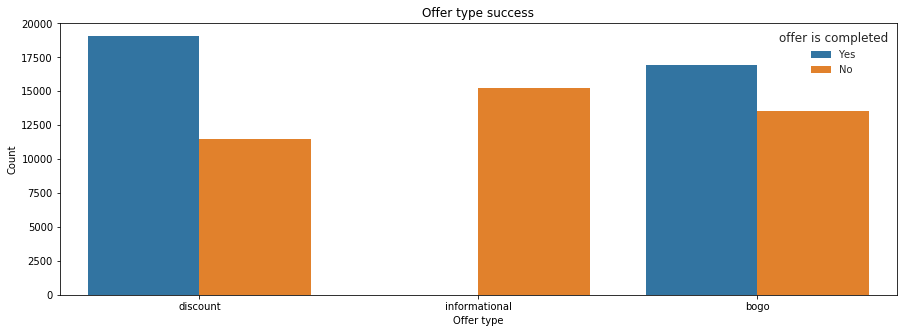

In [36]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "completed_offer", data=combined_df)
sns.set(style="darkgrid")
plt.title('Offer type success')
plt.ylabel('Count')
plt.xlabel('Offer type')
plt.legend(title='offer is completed')

From the above we understand, a discount has the largest success rate in contrast with bogo.Let's explore which offer is more demanding

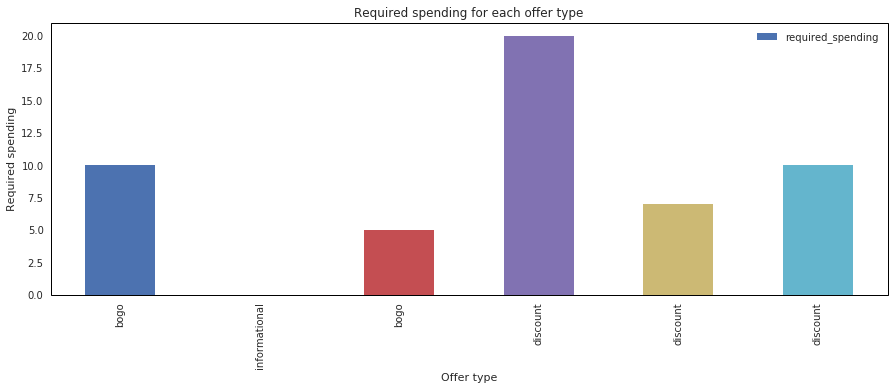

In [37]:
plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  
portfolio[['required_spending','offer_type']].drop_duplicates().plot(kind='bar',x='offer_type',ax=ax,y='required_spending')
plt.title('Required spending for each offer type')
plt.ylabel('Required spending')
plt.xlabel('Offer type')
plt.grid(False)

We can se from the above plot that discount seems to be more demanding but not overall.

There are bogo offers which can be more or equivalently demanding with discount.

Beyond that, as expected we can be sure from the last 2 graphs, informational offers are out of competition. They are just infromational messages to customers and they do not require any spending and they do not provide the chance for a reward.

In order to explore better the success rate of each offer type, it would be more efficient to combine bogo and discount offers  with their respective spending requirement and exclude informational offers from the results.

In [38]:
combined_df.loc[((combined_df.offer_type=="discount") & (combined_df.required_spending==7)),'offer_type_and_difficulty']='discount_spend_7'
combined_df.loc[((combined_df.offer_type=="discount") & (combined_df.required_spending==10)),'offer_type_and_difficulty']='discount_spend_10'
combined_df.loc[((combined_df.offer_type=="discount") & (combined_df.required_spending==20)),'offer_type_and_difficulty']='discount_spend_20'
combined_df.loc[((combined_df.offer_type=="bogo") & (combined_df.required_spending==5)),'offer_type_and_difficulty']='bogo_spend_5'
combined_df.loc[((combined_df.offer_type=="bogo") & (combined_df.required_spending==10)),'offer_type_and_difficulty']='bogo_spend_10'
combined_df.loc[(combined_df.offer_type=="informational" ),'offer_type_and_difficulty']='informational'

combined_df.head()

,customer_id,offer_id,offer_type,email,mobile,social,web,required_spending,duration_days,time_received,time_viewed,days_first_trans,time_completed,reward_amount,received_2_view,view_2_complete,receive_2_complete,offer_success,age,became_member_on,gender,income,completed_offer,offer_viewed,offer_type_and_difficulty
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1.00,1.00,0.00,1.00,10.00,7.00,24.00,nan,27.50,24.00,2.00,nan,nan,0.00,1.00,33.00,20170421,M,72000.00,Yes,0.00,discount_spend_10
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1.00,1.00,0.00,1.00,0.00,4.00,14.00,15.50,17.25,nan,nan,1.50,nan,nan,0.00,33.00,20170421,M,72000.00,No,1.00,informational
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,1.00,1.00,1.00,0.00,0.00,3.00,7.00,8.00,9.50,nan,nan,1.00,nan,nan,0.00,33.00,20170421,M,72000.00,No,1.00,informational
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1.00,1.00,1.00,1.00,5.00,5.00,17.00,19.00,17.25,17.25,5.00,2.00,-1.75,0.25,1.00,33.00,20170421,M,72000.00,Yes,1.00,bogo_spend_5
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1.00,1.00,1.00,1.00,10.00,10.00,21.00,22.50,22.00,22.00,2.00,1.50,-0.50,1.00,1.00,33.00,20170421,M,72000.00,Yes,1.00,discount_spend_10


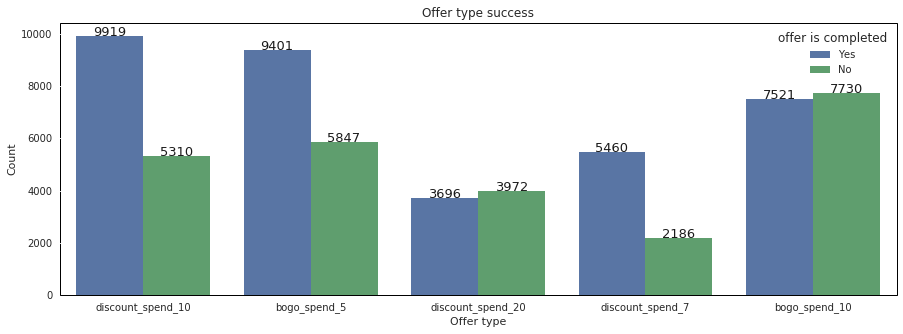

In [39]:
plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  
ax1=sns.countplot(x= "offer_type_and_difficulty", hue= "completed_offer", data=combined_df[combined_df.offer_type!="informational"])
sns.set(style="darkgrid")
plt.title('Offer type success')
plt.ylabel('Count')
plt.xlabel('Offer type')
plt.legend(title='offer is completed')
totals = []

# find the values and append to list
for i in ax1.patches:
    totals.append(i.get_height())

# set individual bar lables using above list

# set individual bar lables using above list
#source: https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
for i in ax1.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax1.text(i.get_x()+.1, i.get_height()+2, \
            str(round(i.get_height(), 2)), fontsize=13,
                color='0.1')


The above graph shows that:
    
1) discount offer with requirement spending 7, is the most successfull offer with success rate: 71.4%

2) offers discount with required spending 10 and bogo with required spending 5 are quite succesfull with success rate: 65.1% and 61.7% correspondingly

3) The most expensive choices for both types expectedly have the lower success rates. These are bogo with required spending 10 and discount with required spending 20 and their respective success rates are: 49.3% and 50.2% correspondingly

4) The most frequent offer types are bogo with required spending 10, discount with required spending 10 and bogo with required spending 5.

Therefore, a more frequent offer to customers about discount with required spending 7 or 10 against to bogo offers with required spending 10 seems the most obvious action that should be taken.

Customer seems to respond quite better in cheaper bogo offers, where they have to spend less money in order to buy double quantity of the offered product.

For the same level of prices (required amount that should be spent) discount offers seems to work more efficiently. So, bogo offers at a spending level of 10 should be reduced in favour of discount offers with required amount to psend 7 or 10.



Let's have a better insight in demographics of the analysis.


In [40]:
comb=combined_df[['customer_id','gender']].drop_duplicates()

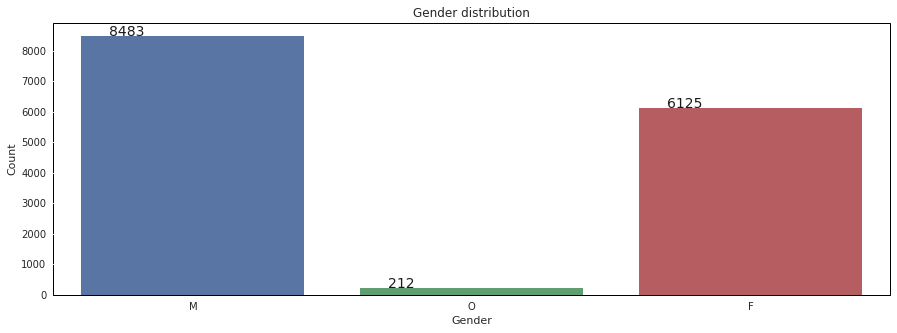

In [41]:
plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1') 

ax1=sns.countplot(x= "gender", data=comb)

sns.set(style="darkgrid")
plt.title('Gender distribution')
plt.ylabel('Count')
plt.xlabel('Gender')

# find the values and append to list
for i in ax1.patches:
    totals.append(i.get_height())

# set individual bar lables using above list

# set individual bar lables using above list
#source: https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
for i in ax1.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax1.text(i.get_x()+.1, i.get_height()+2, \
            str(round(i.get_height(), 2)), fontsize=14,
                color='0.1')


We observe that the majority of the customers who were included in the analysis are male 57.2%.
Females were 41.3% and 1.4% of the customers other gender orientation.

We have to mention here that for 2175 customers there was not available information about their age, gender and income.
We will decide later if these cases will be included in the 2nd part of the analysis 

,income
count,14825.00
mean,65404.99
std,21598.30
min,30000.00
25%,49000.00
50%,64000.00
75%,80000.00
max,120000.00


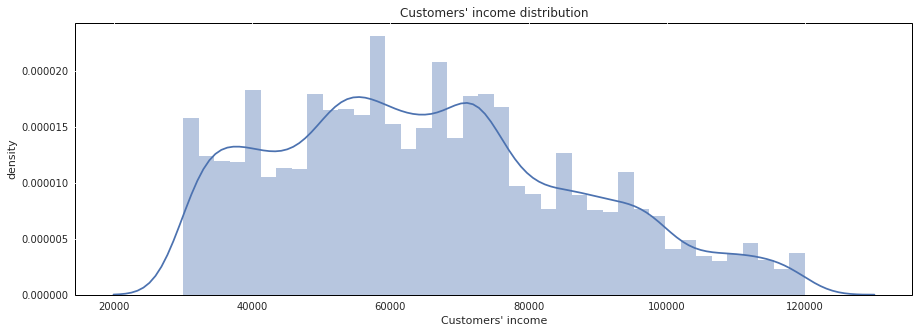

In [42]:
plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  

ax1=sns.distplot(profile[profile.income.notna()]['income'], bins=40, hist_kws={'alpha': 0.4})

plt.title("Customers' income distribution")
plt.ylabel('density')
plt.xlabel("Customers' income")

pd.DataFrame(profile[profile.income.notna()]['income'].describe())

We observe that the income is concetrated mainly in range 30-80k. From 80k and above that we have less cases.

Let's do the same for the age of the customers

,age
count,14825.00
mean,54.39
std,17.38
min,18.00
25%,42.00
50%,55.00
75%,66.00
max,101.00


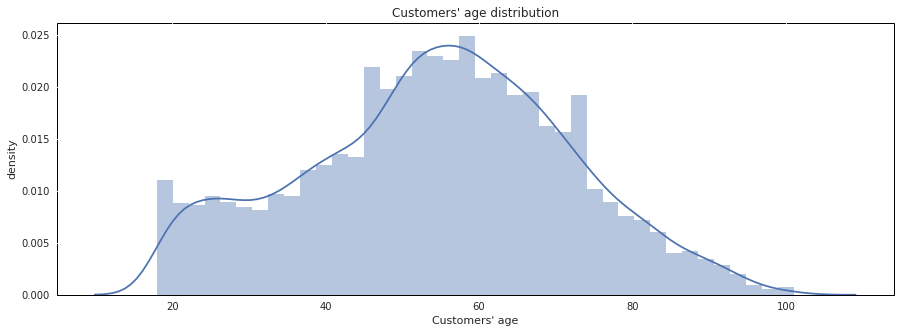

In [43]:
plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  

ax1=sns.distplot(profile[profile.age.notna()]['age'], bins=40, hist_kws={'alpha': 0.4})

plt.title("Customers' age distribution")
plt.ylabel('density')
plt.xlabel("Customers' age")

pd.DataFrame(profile[profile.income.notna()]['age'].describe())

We observe that the majority of the clients are between 40 and 65, but with very sound density in younger ages, too


In order to have a better control over the above information we will create bands for income and age 

In [44]:
# income bands
combined_df.loc[(combined_df.income<40000),'income_bands']='a_less_than_40k'
combined_df.loc[((combined_df.income>=40000) & (combined_df.income<50000)),'income_bands']='b_40k_to_50k'
combined_df.loc[((combined_df.income>=50000) & (combined_df.income<60000)),'income_bands']='c_50k_to_60k'
combined_df.loc[((combined_df.income>=60000) & (combined_df.income<70000)),'income_bands']='d_60k_to_70k'
combined_df.loc[((combined_df.income>=70000) & (combined_df.income<80000)),'income_bands']='e_70k_to_80k'
combined_df.loc[((combined_df.income>=80000) & (combined_df.income<90000)),'income_bands']='f_80k_to_90k'
combined_df.loc[((combined_df.income>=90000) & (combined_df.income<100000)),'income_bands']='g_90k_to_100k'
combined_df.loc[((combined_df.income>=100000)),'income_bands']='h_more_than_100k'

# age bands
combined_df.loc[(combined_df.age<25),'age_bands']='a_less_than_25_yrs'
combined_df.loc[((combined_df.age>=25) & (combined_df.age<35)),'age_bands']='b_25_to_35_yrs'
combined_df.loc[((combined_df.age>=35) & (combined_df.age<45)),'age_bands']='c_35_to_45_yrs'
combined_df.loc[((combined_df.age>=45) & (combined_df.age<55)),'age_bands']='d_45_to_55_yrs'
combined_df.loc[((combined_df.age>=55) & (combined_df.age<65)),'age_bands']='e_55_to_65_yrs'
combined_df.loc[((combined_df.age>=65) & (combined_df.age<75)),'age_bands']='f_65_to_75_yrs'
combined_df.loc[((combined_df.age>=75) & (combined_df.age<85)),'age_bands']='g_75_to_85_yrs'
combined_df.loc[((combined_df.age>=85)),'age_bands']='f_over_85_yrs'

combined_df.head()

,customer_id,offer_id,offer_type,email,mobile,social,web,required_spending,duration_days,time_received,time_viewed,days_first_trans,time_completed,reward_amount,received_2_view,view_2_complete,receive_2_complete,offer_success,age,became_member_on,gender,income,completed_offer,offer_viewed,offer_type_and_difficulty,income_bands,age_bands
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1.00,1.00,0.00,1.00,10.00,7.00,24.00,nan,27.50,24.00,2.00,nan,nan,0.00,1.00,33.00,20170421,M,72000.00,Yes,0.00,discount_spend_10,e_70k_to_80k,b_25_to_35_yrs
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1.00,1.00,0.00,1.00,0.00,4.00,14.00,15.50,17.25,nan,nan,1.50,nan,nan,0.00,33.00,20170421,M,72000.00,No,1.00,informational,e_70k_to_80k,b_25_to_35_yrs
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,1.00,1.00,1.00,0.00,0.00,3.00,7.00,8.00,9.50,nan,nan,1.00,nan,nan,0.00,33.00,20170421,M,72000.00,No,1.00,informational,e_70k_to_80k,b_25_to_35_yrs
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1.00,1.00,1.00,1.00,5.00,5.00,17.00,19.00,17.25,17.25,5.00,2.00,-1.75,0.25,1.00,33.00,20170421,M,72000.00,Yes,1.00,bogo_spend_5,e_70k_to_80k,b_25_to_35_yrs
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1.00,1.00,1.00,1.00,10.00,10.00,21.00,22.50,22.00,22.00,2.00,1.50,-0.50,1.00,1.00,33.00,20170421,M,72000.00,Yes,1.00,discount_spend_10,e_70k_to_80k,b_25_to_35_yrs


Text(0.5,0,"Customers' income")

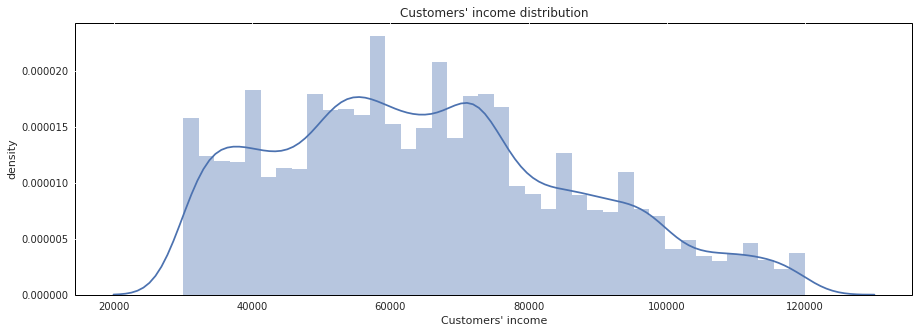

In [45]:
plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  

ax1=sns.distplot(profile[profile.income.notna()]['income'], bins=40, hist_kws={'alpha': 0.4})

plt.title("Customers' income distribution")
plt.ylabel('density')
plt.xlabel("Customers' income")

In [46]:
comb=combined_df[['customer_id','gender','age_bands','income_bands']].drop_duplicates().sort_values(by=['age_bands','gender'])


Now let's have a better insight of the demographics of customers who participated in the analysis.



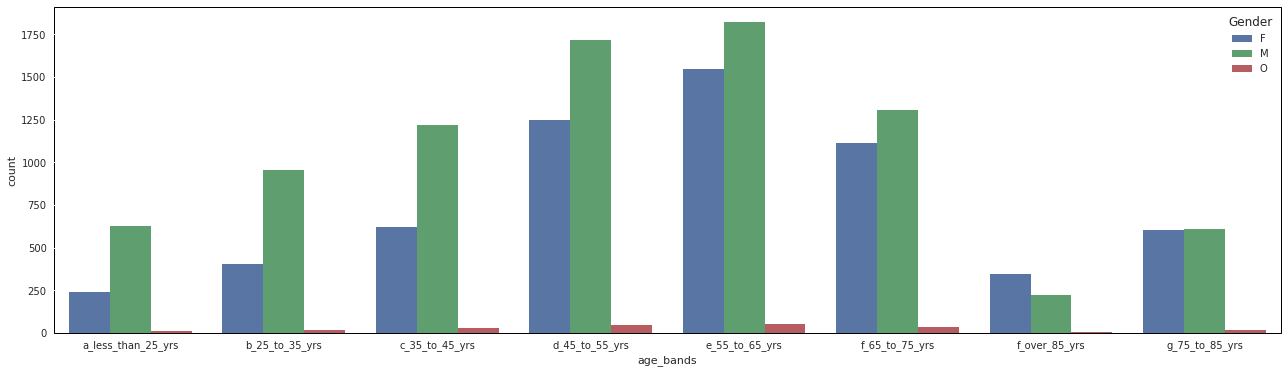

In [47]:
fig, axs = plt.subplots(ncols=1,figsize=(22,6))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  

sns.countplot(x=comb.age_bands ,
                 hue=comb.gender)

plt.legend(title='Gender',prop={'size':10})

plt.show()

Female presense in test is more frequent proportionally, as are moving towards older ages

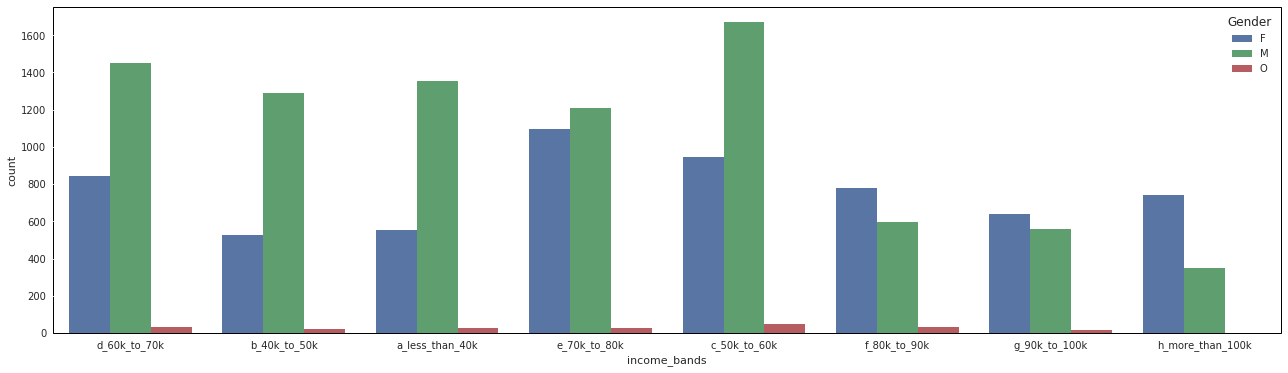

In [48]:
fig, axs = plt.subplots(ncols=1,figsize=(22,6))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  

sns.countplot(x=comb.income_bands ,
                 hue=comb.gender)

plt.legend(title='Gender',prop={'size': 10})
plt.show()

Female participants in the analysis tend to have bigger income than males or other orientations.

It is also interesting to find out who respond better in offers, from a demofraphics prespective

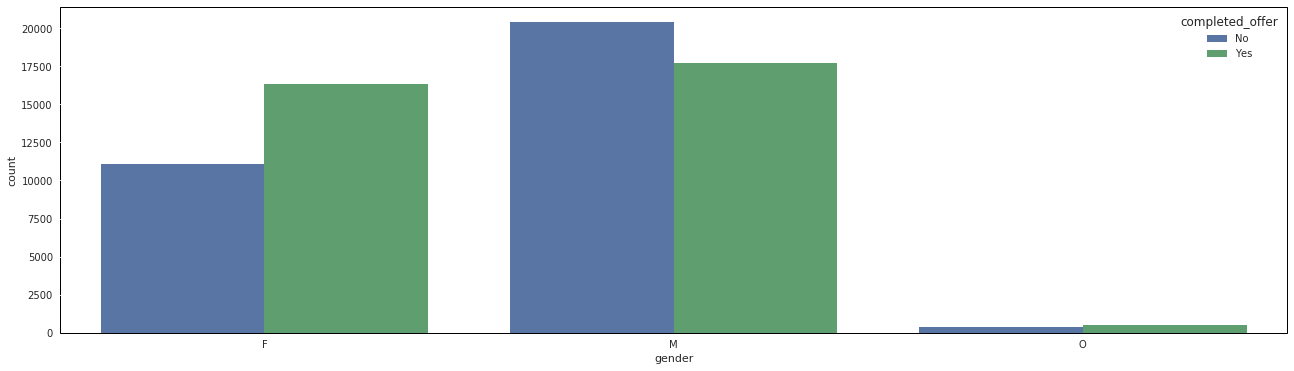

In [49]:
combined_df=combined_df.sort_values(by=['gender','completed_offer'])

fig, axs = plt.subplots(ncols=1,figsize=(22,6))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  

sns.countplot(x=combined_df.gender ,
                 hue=combined_df.completed_offer)

plt.legend(title='completed_offer',prop={'size': 10})
plt.show()

Females have the hight respond rate in offers. After them, people with a non-binary gender orientation with proportionally high rates.

On the other hands male seem to not respond in offers as much as people do in other two categories.

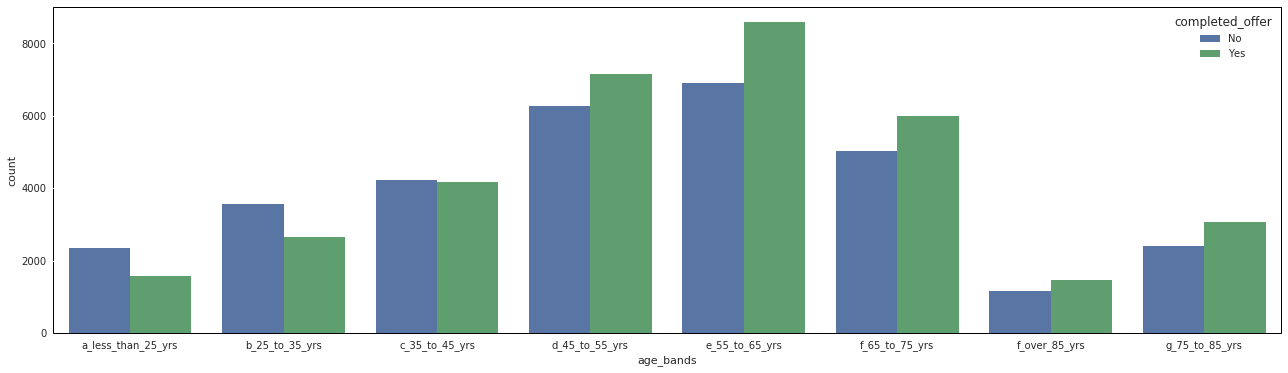

In [50]:
combined_df=combined_df.sort_values(by=['age_bands','completed_offer'])

fig, axs = plt.subplots(ncols=1,figsize=(22,6))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  

sns.countplot(x=combined_df.age_bands ,
                 hue=combined_df.completed_offer)

plt.legend(title='completed_offer',prop={'size': 10})
plt.show()

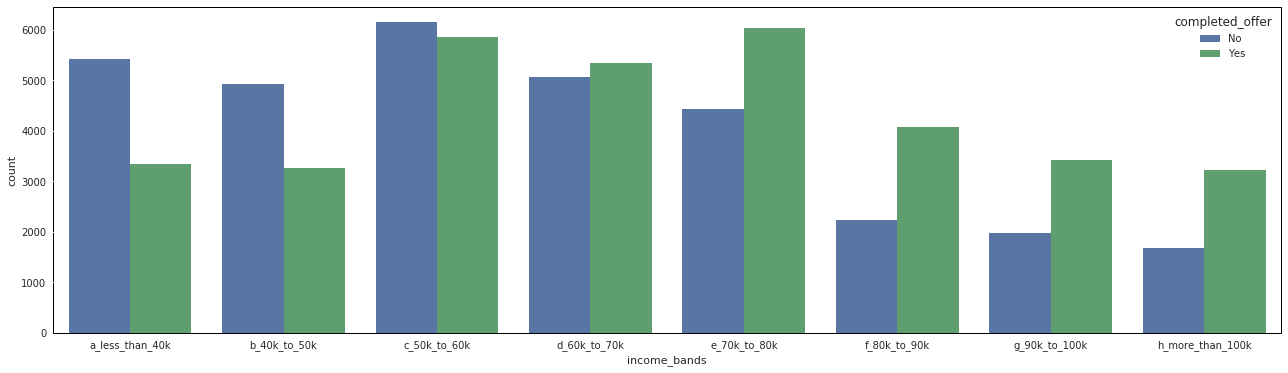

In [51]:
combined_df=combined_df.sort_values(by=['income_bands','completed_offer'])

fig, axs = plt.subplots(ncols=1,figsize=(22,6))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  

sns.countplot(x=combined_df.income_bands ,
                 hue=combined_df.completed_offer)

plt.legend(title='completed_offer',prop={'size': 10})
plt.show()

In [52]:
# age bands                                   
combined_df.loc[(combined_df.became_member_on<20140000),'member_since_year']='a_member_since_2013'
combined_df.loc[((combined_df.became_member_on>=20140000) & (combined_df.became_member_on<20150000)),'member_since_year']='b_member_since_2014'
combined_df.loc[((combined_df.became_member_on>=20150000) & (combined_df.became_member_on<20160000)),'member_since_year']='c_member_since_2015'
combined_df.loc[((combined_df.became_member_on>=20160000) & (combined_df.became_member_on<20170000)),'member_since_year']='d_member_since_2016'
combined_df.loc[((combined_df.became_member_on>=20170000) & (combined_df.became_member_on<20180000)),'member_since_year']='e_member_since_2017'
combined_df.loc[((combined_df.became_member_on>=20180000)),'member_since_year']='f_member_since_2018'
combined_df.head()

,customer_id,offer_id,offer_type,email,mobile,social,web,required_spending,duration_days,time_received,time_viewed,days_first_trans,time_completed,reward_amount,received_2_view,view_2_complete,receive_2_complete,offer_success,age,became_member_on,gender,income,completed_offer,offer_viewed,offer_type_and_difficulty,income_bands,age_bands,member_since_year
449,019be0c6f8fd4000b1967c7308b4bdf4,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1.00,1.00,1.00,1.00,10.00,5.00,7.00,11.50,9.25,nan,nan,4.50,nan,nan,0.00,23.00,20151108,F,33000.00,No,1.00,bogo_spend_10,a_less_than_40k,a_less_than_25_yrs,c_member_since_2015
451,019be0c6f8fd4000b1967c7308b4bdf4,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1.00,1.00,1.00,0.00,10.00,7.00,14.00,15.50,15.50,nan,nan,1.50,nan,nan,0.00,23.00,20151108,F,33000.00,No,1.00,bogo_spend_10,a_less_than_40k,a_less_than_25_yrs,c_member_since_2015
769,02c083884c7d45b39cc68e1314fec56c,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1.00,0.00,0.00,1.00,20.00,10.00,17.00,nan,17.50,nan,nan,nan,nan,nan,0.00,20.00,20160711,F,30000.00,No,0.00,discount_spend_20,a_less_than_40k,a_less_than_25_yrs,d_member_since_2016
770,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1.00,1.00,1.00,0.00,10.00,7.00,0.00,0.00,0.25,nan,nan,0.00,nan,nan,0.00,20.00,20160711,F,30000.00,No,1.00,bogo_spend_10,a_less_than_40k,a_less_than_25_yrs,d_member_since_2016
2248,07dc543bf5d24eb9893c1a3f199f275f,3f207df678b143eea3cee63160fa8bed,informational,1.00,1.00,0.00,1.00,0.00,4.00,14.00,nan,14.75,nan,nan,nan,nan,nan,0.00,20.00,20160824,F,30000.00,No,0.00,informational,a_less_than_40k,a_less_than_25_yrs,d_member_since_2016


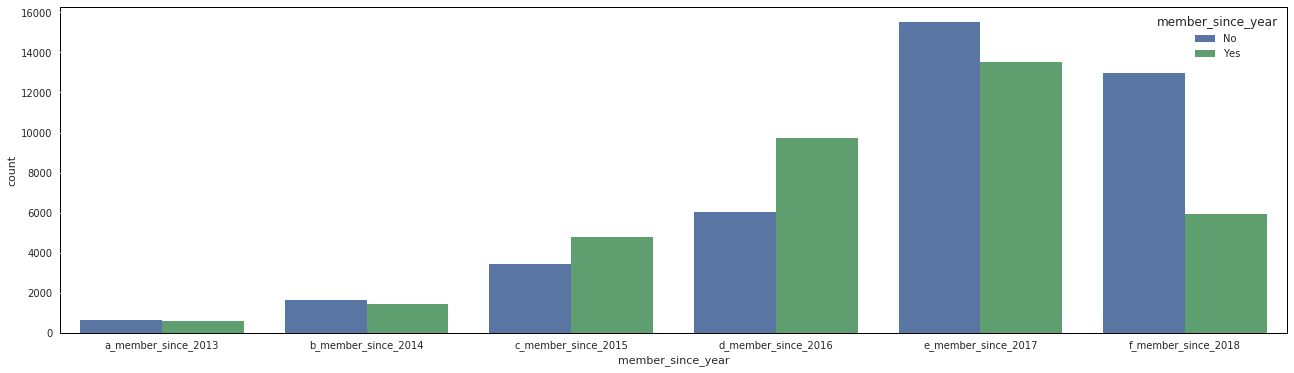

In [53]:
combined_df=combined_df.sort_values(by=['member_since_year','completed_offer'])

fig, axs = plt.subplots(ncols=1,figsize=(22,6))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  

sns.countplot(x=combined_df.member_since_year ,
                 hue=combined_df.completed_offer)

plt.legend(title='member_since_year',prop={'size': 10})
plt.show()

From the last 3 graphs we conclude that people in older age groups and with higher incomes tend to respond more in offers compared with younger and people with lower incomes.

In addition to that, people which are older members tend to respond better in offers than the more recent ones

Another usefull information is to explore the association that exist between a positive response to the offer and the fact that customer has viewed the offer. This will help us to understand how much the fact of a customer viewes offer contributes in the final response rate.

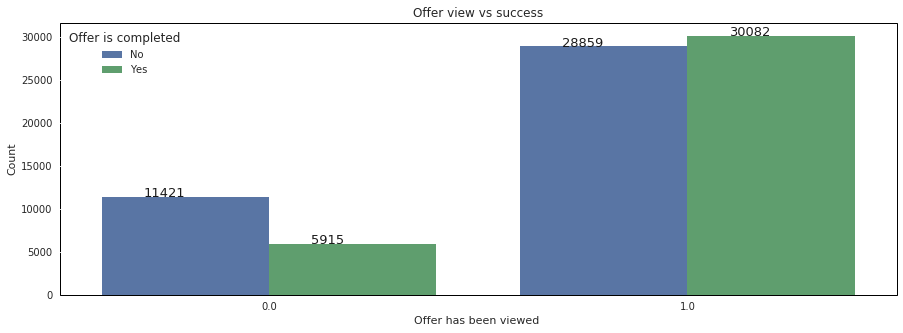

In [54]:
plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')  
ax1=sns.countplot(x= "offer_viewed", hue= "completed_offer", data=combined_df)
sns.set(style="darkgrid")
plt.title('Offer view vs success')
plt.ylabel('Count')
plt.xlabel('Offer has been viewed ')
plt.legend(title='Offer is completed')
totals = []

# find the values and append to list
for i in ax1.patches:
    totals.append(i.get_height())

# set individual bar lables using above list

# set individual bar lables using above list
#source: https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
for i in ax1.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax1.text(i.get_x()+.1, i.get_height()+2, \
            str(round(i.get_height(), 2)), fontsize=13,
                color='0.1')


From the graph above, we understand that there is strong association between respond rate of an offer and the fact that customer has viewed the offer. In that case more than half of the cases the customer will respond successfully.

It is very interesting to study the cases where customer has not seen the offer.

Based on the results for those who have viewed the offer, it is a reasonable guess to expect that half of cases that have not seen the offer and they did not respond successfully, might have acted differently. So here we can detect a quite significant opportunity loss for the company.

At the next step, we explore the demographics of the cases where customers have fulfilled the requirements to respond succefullythe offer without having viewed it. This is opportunity cost for the company. These customers tend to consume without having an offer, while these offers could have been directed to people who view offers and can respond successfully to them.

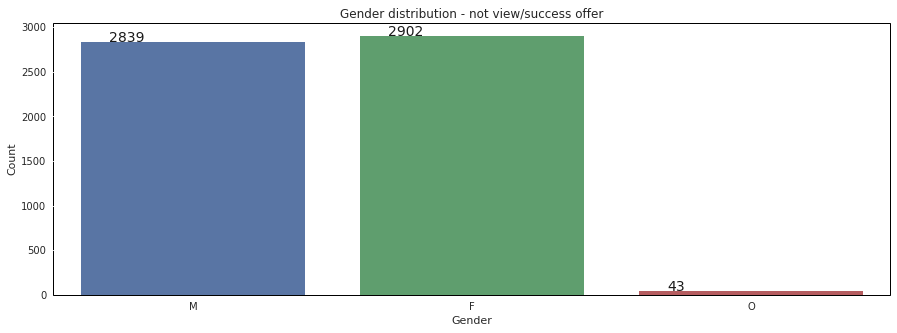

In [55]:
not_view_success=combined_df[(combined_df.offer_viewed==0) & (combined_df.completed_offer=='Yes')]

plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1') 

ax1=sns.countplot(x= "gender", data=not_view_success)

sns.set(style="darkgrid")
plt.title('Gender distribution - not view/success offer')
plt.ylabel('Count')
plt.xlabel('Gender')
totals = []

# find the values and append to list
for i in ax1.patches:
    totals.append(i.get_height())

# set individual bar lables using above list

# set individual bar lables using above list
#source: https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
for i in ax1.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax1.text(i.get_x()+.1, i.get_height()+2, \
            str(round(i.get_height(), 2)), fontsize=14,
                color='0.1')


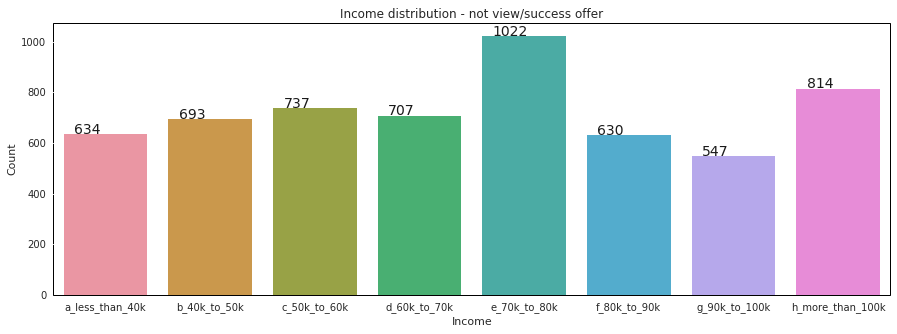

In [56]:

plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1') 

ax1=sns.countplot(x= "income_bands", data=not_view_success)

sns.set(style="darkgrid")
plt.title('Income distribution - not view/success offer')
plt.ylabel('Count')
plt.xlabel('Income')
totals = []

# find the values and append to list
for i in ax1.patches:
    totals.append(i.get_height())

# set individual bar lables using above list

# set individual bar lables using above list
#source: https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
for i in ax1.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax1.text(i.get_x()+.1, i.get_height()+2, \
            str(round(i.get_height(), 2)), fontsize=14,
                color='0.1')


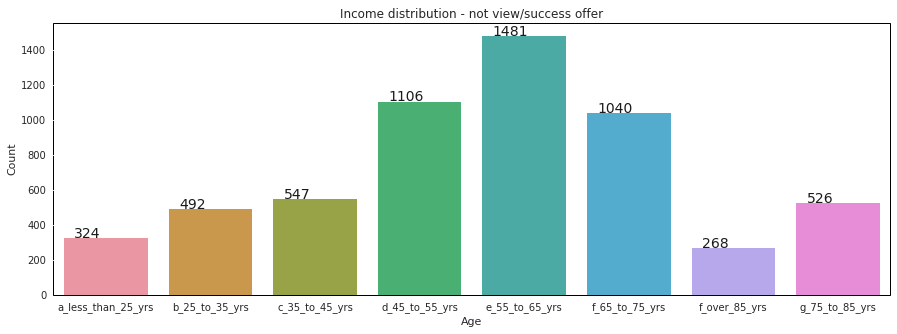

In [57]:

plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.set_facecolor("w")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1') 

ax1=sns.countplot(x= "age_bands", data=not_view_success)

sns.set(style="darkgrid")
plt.title('Income distribution - not view/success offer')
plt.ylabel('Count')
plt.xlabel('Age')
totals = []

# find the values and append to list
for i in ax1.patches:
    totals.append(i.get_height())

# set individual bar lables using above list

# set individual bar lables using above list
#source: https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
for i in ax1.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax1.text(i.get_x()+.1, i.get_height()+2, \
            str(round(i.get_height(), 2)), fontsize=14,
                color='0.1')


Above results show that people with income between 70k-80k or people whose age is between 65 to 75 tend to have high success rates in offers without having viewed them.

But these two groups have among the highest success rate overall, so it is not wise to penalize these groups in favour of the others, expecting that offers' response rate to be higher and more efficient.

The best thing to do, is to try to build amodel which will provide indications which customer is more likely to respond to an offer

### C. Modelling on response rate

At the 3rd part of this analysis, we will build a model which will try to predict better when a customer is more likely to respond successfully in an offer.

From data processing, we have seen that one customer might be given more than once the same offer. This means that the couple of information: customer_id & offer_id is not unique. 

So, we consider as a unique case every signle time that a specific offer is given to a specific customer. So unique values are defined by the triple combination of customer_id, offer_id & time_received.

Despite that, we know that from profile DataFrame, there were about 2k cases for which we do not have any demographics for customers that pariticipate in the analysis. We will exclude them, but before we do that we will explore if the respond rate in an offer will change by removing these cases

In [58]:
#Before we set up a column that identify missing cases, we will remove from the analysis the cases about informational offer types
combined_df=combined_df.drop(combined_df[(combined_df.offer_type=="informational")].index)

#No we define the column which identifiess missing values for demographics 
combined_df.loc[(combined_df.income.notna()),'Missing']='No'
combined_df.loc[(combined_df.income.isnull()),'Missing']='Yes'


In [59]:
pd.crosstab(combined_df.Missing, combined_df.completed_offer)

completed_offer,No,Yes
Missing,,
No,18584,34617
Yes,6461,1380


We see that by removing these cases the response rate increases from 59% to 65%. It is interesting that for these cases we have some people who responded successfully in the offer. But from analytics point of view, there is no available information from them that can be used in order to understand better the profile of those who respond in an offer. So we will exclude them. 

In [60]:
modelling_df=combined_df.drop(combined_df[(combined_df.age.isnull())].index)

modelling_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53201 entries, 53300 to 57976
Data columns (total 29 columns):
customer_id                  53201 non-null object
offer_id                     53201 non-null object
offer_type                   53201 non-null object
email                        53201 non-null float64
mobile                       53201 non-null float64
social                       53201 non-null float64
web                          53201 non-null float64
required_spending            53201 non-null float64
duration_days                53201 non-null float64
time_received                53201 non-null float64
time_viewed                  41274 non-null float64
days_first_trans             49642 non-null float64
time_completed               34617 non-null float64
reward_amount                34617 non-null float64
received_2_view              41274 non-null float64
view_2_complete              28833 non-null float64
receive_2_complete           34617 non-null float64
offer_

In [61]:
modelling_df.head()

,customer_id,offer_id,offer_type,email,mobile,social,web,required_spending,duration_days,time_received,time_viewed,days_first_trans,time_completed,reward_amount,received_2_view,view_2_complete,receive_2_complete,offer_success,age,became_member_on,gender,income,completed_offer,offer_viewed,offer_type_and_difficulty,income_bands,age_bands,member_since_year,Missing
53300,b12e06282edd43a4ace2353f3addf8e8,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1.00,1.00,1.00,1.00,10.00,5.00,7.00,12.25,8.50,nan,nan,5.25,nan,nan,0.00,21.00,20131223,F,37000.00,No,1.00,bogo_spend_10,a_less_than_40k,a_less_than_25_yrs,a_member_since_2013,No
14450,316f9251e7564cc095ba1654556b9315,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1.00,1.00,1.00,0.00,10.00,7.00,7.00,10.25,7.75,nan,nan,3.25,nan,nan,0.00,20.00,20130804,M,39000.00,No,1.00,bogo_spend_10,a_less_than_40k,a_less_than_25_yrs,a_member_since_2013,No
14451,316f9251e7564cc095ba1654556b9315,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1.00,1.00,1.00,1.00,5.00,5.00,17.00,17.00,17.50,nan,nan,0.00,nan,nan,0.00,20.00,20130804,M,39000.00,No,1.00,bogo_spend_5,a_less_than_40k,a_less_than_25_yrs,a_member_since_2013,No
33079,6efb398bbf994e2390f7f5063fb54702,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1.00,1.00,0.00,1.00,5.00,7.00,0.00,3.25,1.50,nan,nan,3.25,nan,nan,0.00,22.00,20130911,M,35000.00,No,1.00,bogo_spend_5,a_less_than_40k,a_less_than_25_yrs,a_member_since_2013,No
33080,6efb398bbf994e2390f7f5063fb54702,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1.00,1.00,0.00,1.00,5.00,7.00,14.00,14.25,14.25,nan,nan,0.25,nan,nan,0.00,22.00,20130911,M,35000.00,No,1.00,bogo_spend_5,a_less_than_40k,a_less_than_25_yrs,a_member_since_2013,No


For the model we will use the following list of variables, out of which we will create the corresponding dummys variables for each level of the variables:

1) email

2) mobile

3) social

4) web 

5) duration_days                

6) gender

7) offer_type_and_difficulty

8) income_bands

9) age_bands

10) member_since_year

11) offer_success (response variable)

The first 4 columns indicate the channel where each offer can be distributed and they are already in a binary state.

We will transform the rest 6  variables into dummies.

In [62]:
def create_dummy_df(df,cols):
    '''
    This function will be used in order to create dummy variables
    for each categorical variable that is included in the decalred dataframe and drops the categorical variables:
    
    df: Dataframe in which we will create dummy variables
    
    cols: Theset of columns for whichw will create the dummy variables
    '''
    
    i=-1
    cat_cols=cols
    for column in cat_cols:
        i=i+1
        df=pd.merge(df.drop([column],axis=1), 
                pd.get_dummies(df[[column]], prefix=cat_cols[i], drop_first=True,dummy_na=False), 
                left_index=True, right_index=True)
     
    return df

In [63]:
modelling_df2=create_dummy_df(modelling_df[['email','mobile','social','web','duration_days','gender','offer_type_and_difficulty',
                                            'income_bands','age_bands','member_since_year','offer_success']],
                              ['duration_days','gender','offer_type_and_difficulty',
                                'income_bands','age_bands','member_since_year'])

modelling_df2.head()

,email,mobile,social,web,offer_success,duration_days,gender_M,gender_O,offer_type_and_difficulty_bogo_spend_5,offer_type_and_difficulty_discount_spend_10,offer_type_and_difficulty_discount_spend_20,offer_type_and_difficulty_discount_spend_7,income_bands_b_40k_to_50k,income_bands_c_50k_to_60k,income_bands_d_60k_to_70k,income_bands_e_70k_to_80k,income_bands_f_80k_to_90k,income_bands_g_90k_to_100k,income_bands_h_more_than_100k,age_bands_b_25_to_35_yrs,age_bands_c_35_to_45_yrs,age_bands_d_45_to_55_yrs,age_bands_e_55_to_65_yrs,age_bands_f_65_to_75_yrs,age_bands_f_over_85_yrs,age_bands_g_75_to_85_yrs,member_since_year_b_member_since_2014,member_since_year_c_member_since_2015,member_since_year_d_member_since_2016,member_since_year_e_member_since_2017,member_since_year_f_member_since_2018
53300,1.00,1.00,1.00,1.00,0.00,5.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14450,1.00,1.00,1.00,0.00,0.00,7.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14451,1.00,1.00,1.00,1.00,0.00,5.00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33079,1.00,1.00,0.00,1.00,0.00,7.00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33080,1.00,1.00,0.00,1.00,0.00,7.00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Having finished preparation of our modelling data, we will create a grid_search of different models over a machine learning pipeline, in order to have results from the best combination of different models with several states of their hyperparameters

In [64]:
X = modelling_df2.drop(columns=['offer_success'],axis=1)
Y = modelling_df2['offer_success']

We will set up the pipeline and the parameters which are a collection of models which will be assessed by grid_search in order to keep the best solution

In [65]:
# Create a pipeline
pipeline = Pipeline([('clf', GradientBoostingClassifier())]) 
    
# Candidate learning algorithms 
parameters = [
                {'clf': [KNeighborsClassifier()]}, 
                           
                {'clf': [RandomForestClassifier()]},
                           
                {'clf': [GradientBoostingClassifier()]},                           
                         
                {'clf': [LogisticRegression()]}
                
               ]

# Create grid search 
cv = GridSearchCV(pipeline, parameters)

In [66]:
#Split X,Y data in train and test dataframes
X_train, X_test, y_train, y_test = train_test_split(X, Y)


#Train pipeline
cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
 ...     presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'clf': [KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')]}, {'clf': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None,...y='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=Non

Grid search indicates that the best model solution is the K-Nearest Neighbors. Using that the results of the model are the following output

In [67]:
# Predicted values
y_pred = pd.DataFrame(cv.predict(X_test)).set_index(y_test.index)

#Print results
print("Classification report for {}:".format('y_test'),"\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix for {}:".format('y_test'),"\n")
print(confusion_matrix(y_test, y_pred, labels=np.unique(y_pred)))
print("\n")
y_pred_df=pd.DataFrame(y_pred).rename(columns = {0:"offer_success_pred"})
y_test_df=pd.DataFrame(y_test)

accuracy_df=pd.merge(y_pred_df,y_test_df,left_index=True, right_index=True)
accuracy_df.loc[(accuracy_df.offer_success_pred==accuracy_df.offer_success) , 'accuracy'] = 1
accuracy_df.loc[(accuracy_df.offer_success_pred!=accuracy_df.offer_success) , 'accuracy'] = 0
accuracy=accuracy_df.accuracy.sum()/accuracy_df.accuracy.count()

print("Accuracy of prediction for the model:",accuracy)


Classification report for y_test: 

             precision    recall  f1-score   support

        0.0       0.66      0.46      0.54      4702
        1.0       0.74      0.87      0.80      8599

avg / total       0.71      0.72      0.71     13301

Confusion Matrix for y_test: 

[[2140 2562]
 [1121 7478]]


Accuracy of prediction for the model: 0.723103526051


We see that we have fitted a quite good model which accomplish accuracy and f1-score over 70%. Therefore, model can help company to detect easier the right combination between type of offer and customer and direct the offers to people that are more likely to respond better.